In [52]:
%pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.1 MB/s eta 0:00:00


# Step 0: Import Everything we need

In [38]:
# The Basics
import pandas as pd
import numpy
from pprint import pprint

In [39]:
# The Processing
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# The Modell
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

# Step 1: Loading and Cleaning

In [41]:
#code necessary when running in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#code necessary when running in colab
import json
import pandas as pd

dataset_path = "/content/drive/MyDrive/Effiziensteigerung/colab/News_Category_Dataset_v3.json"

with open(dataset_path, 'r') as file:
    news_data = [json.loads(line) for line in file]

df = pd.DataFrame(news_data)

In [43]:
#code necessary when running locally
#df = pd.read_json("News_Category_Dataset_v3.json", lines=True)
#df.head()

In [44]:
unique_categories = len(df.category.unique())

In [45]:
df = df["short_description"]

df = df.map(lambda x: re.sub('[,\.!?]', '', x))
df = df.map(lambda x: x.lower())

df.head()

,short_description
0,health experts said it is too early to predict...
1,he was subdued by passengers and crew when he ...
2,"""until you have a dog you don't understand wha..."
3,"""accidentally put grown-up toothpaste on my to..."
4,amy cooper accused investment firm franklin te...


In [46]:
def preprocess_data(documents):
    stop_words = stopwords.words("english")
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in documents]
    return texts

processed_texts = preprocess_data(df)

# Step 2: Create a Dictionary and Corpus
Dictionary: Mapping between Words and ID
<br>Corpus: List of Documents as "Bag of Words"

In [47]:
id2word = corpora.Dictionary(processed_texts)

corpus = [id2word.doc2bow(text) for text in processed_texts]

# Step 3: Train the LDA Model
Das Latent Dirichlet Allocation (Latente Dirichlet Zuordnung (LDA)) Verfahren ist ein 3-stufiges Bayesian Model, um Topic Modeling durchzuführen (Blei et al.(2003)). Das Verfahren besteht aus den Teilen:
* **Latent:** Die Themen des Korpuses sind verborgen und müssen aus den Dokumenten und deren Wortverteilung abgeleitet werden (Blei et al. (2003), S. 1007).
* **Dirichlet:** Eine Verteilung, basierend auf dem Bayesian Modell, welche die Prioriverteilung (Anfangswahrscheinlichkeit) für die Themenverteilung in den Dokumenten darstellt und die Parameter beeinflussen wie stark bestimmte Themen in einem Dokument vertreten sind (Blei et al. (2003), S. 1007).
* **Allocation:** Die Prozess der Zuweisung und Verteilung beschreibt wie Wörter den verschiedenen Themen zugeordnet werden und wie die Themen in einem Dokument verteilt sind. Allocation beschreibt wie das Modell Wörter in einem Dokument aufgrund ihrer Wahrscheinlichkeit verschiedenen latenten Themen zugeordnet sind. Die Themen - Wörter verteilung in einem Dokument bildet die Grundlage der Analyse (Blei et al. (2003), S. 1007).

LDA nimmt an das es eine Themenverteilung für jeden Text gibt, welche berechnet wird indem ein Thema aus allen verfügbaren Themen $T={T_1,…,T_K}$ jedem Token ($≈$ Wort) eines Textes zugeordnet wird. Der Nutzer definiert dabei die Anzahl der modellierten Themen $K∈N$. Der Text (oder das Dokument) wird als Corpus bezeichnet und besteht aus Texten $M$ sowie Themen $T$ (Rieger at al. (2020 Juni), S. 120); Blei et al. (2003), S. 997).
Dabei ist $N^m$ die Größe des Textes und $W={W,…,W_V}$ die Menge der Wörter wobei $V∈N$ die Größe des implizierten Vokabulars (die Menge aller eindeutigen Wörter) ist(Rieger et al. (2020 Juni), S. 120).

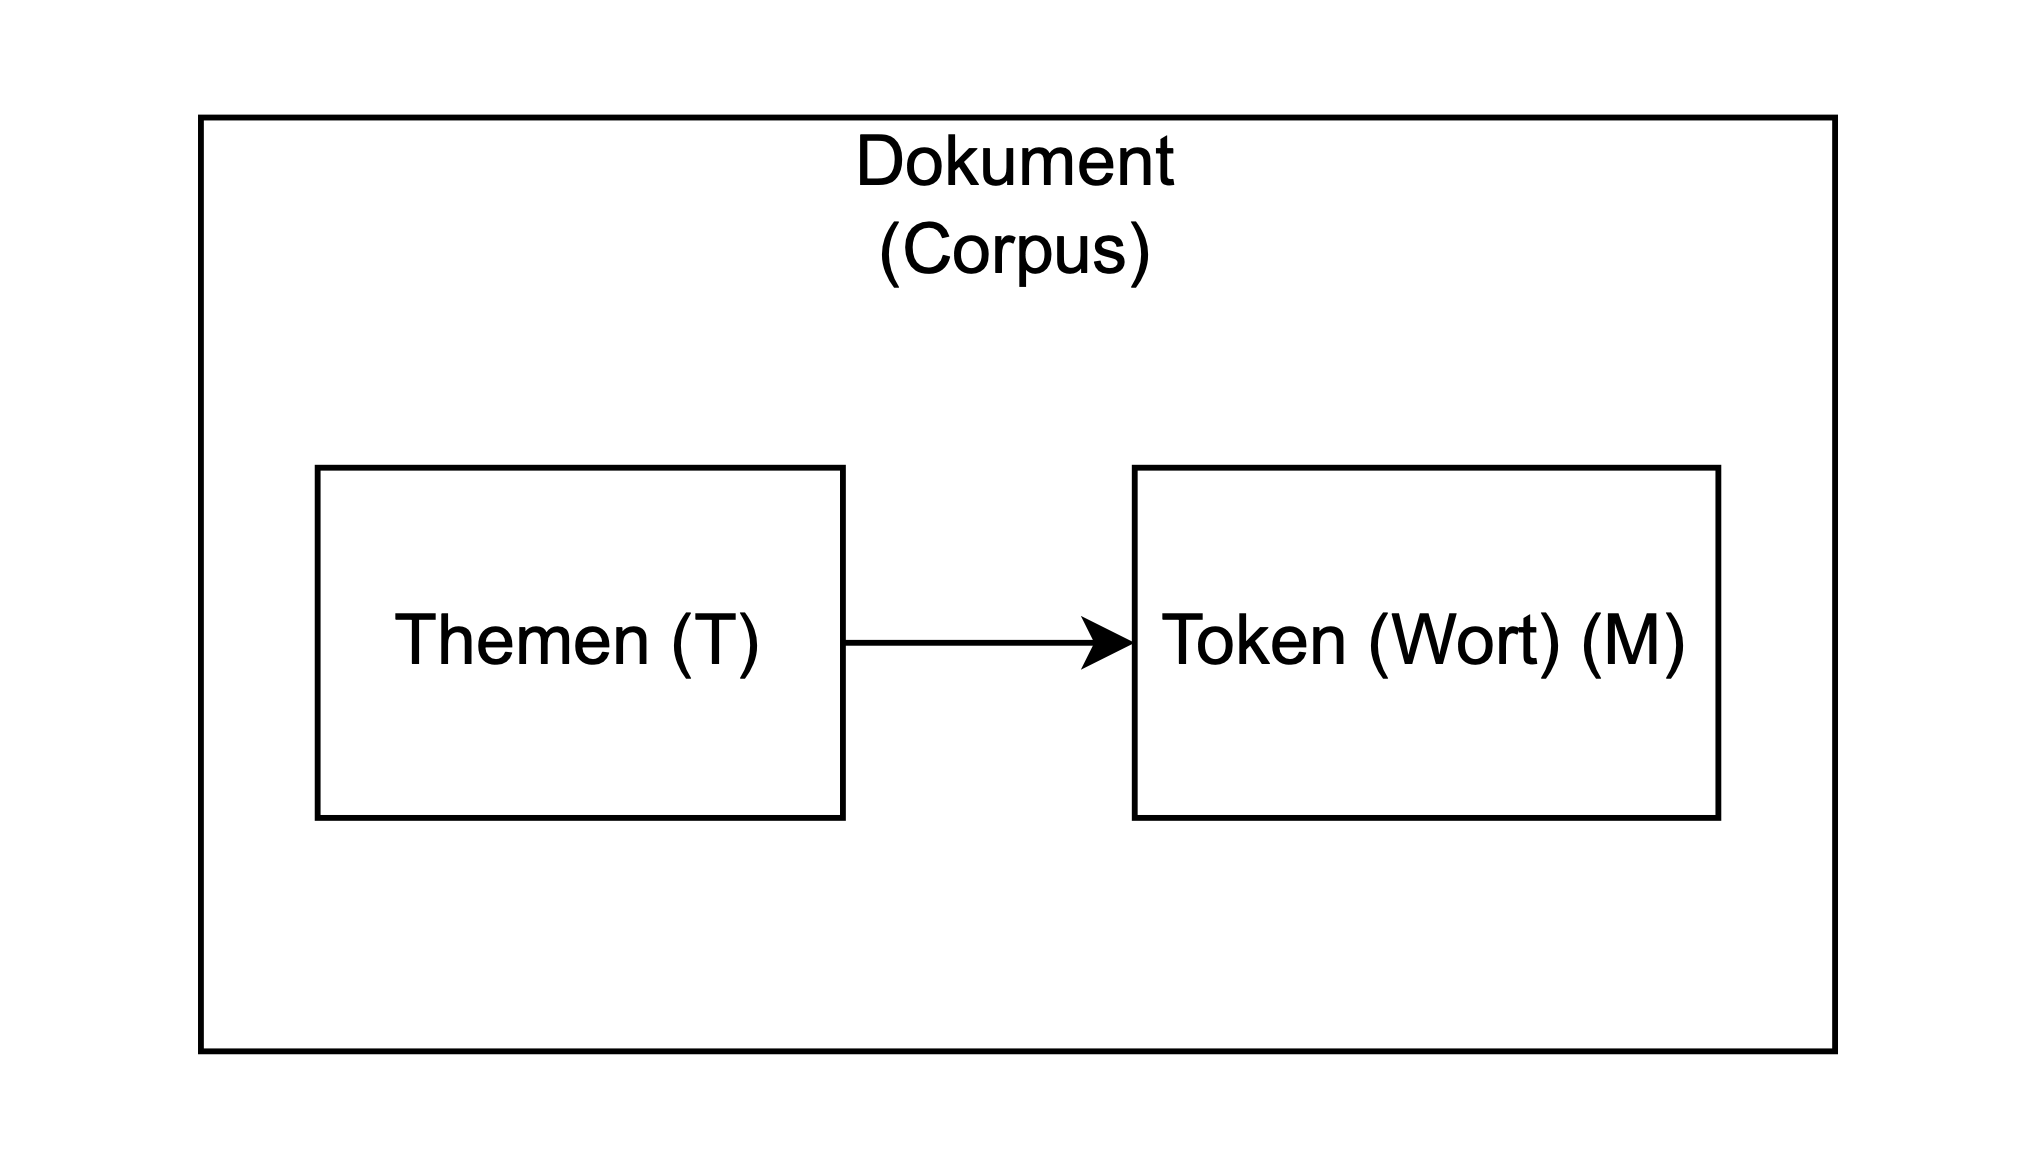


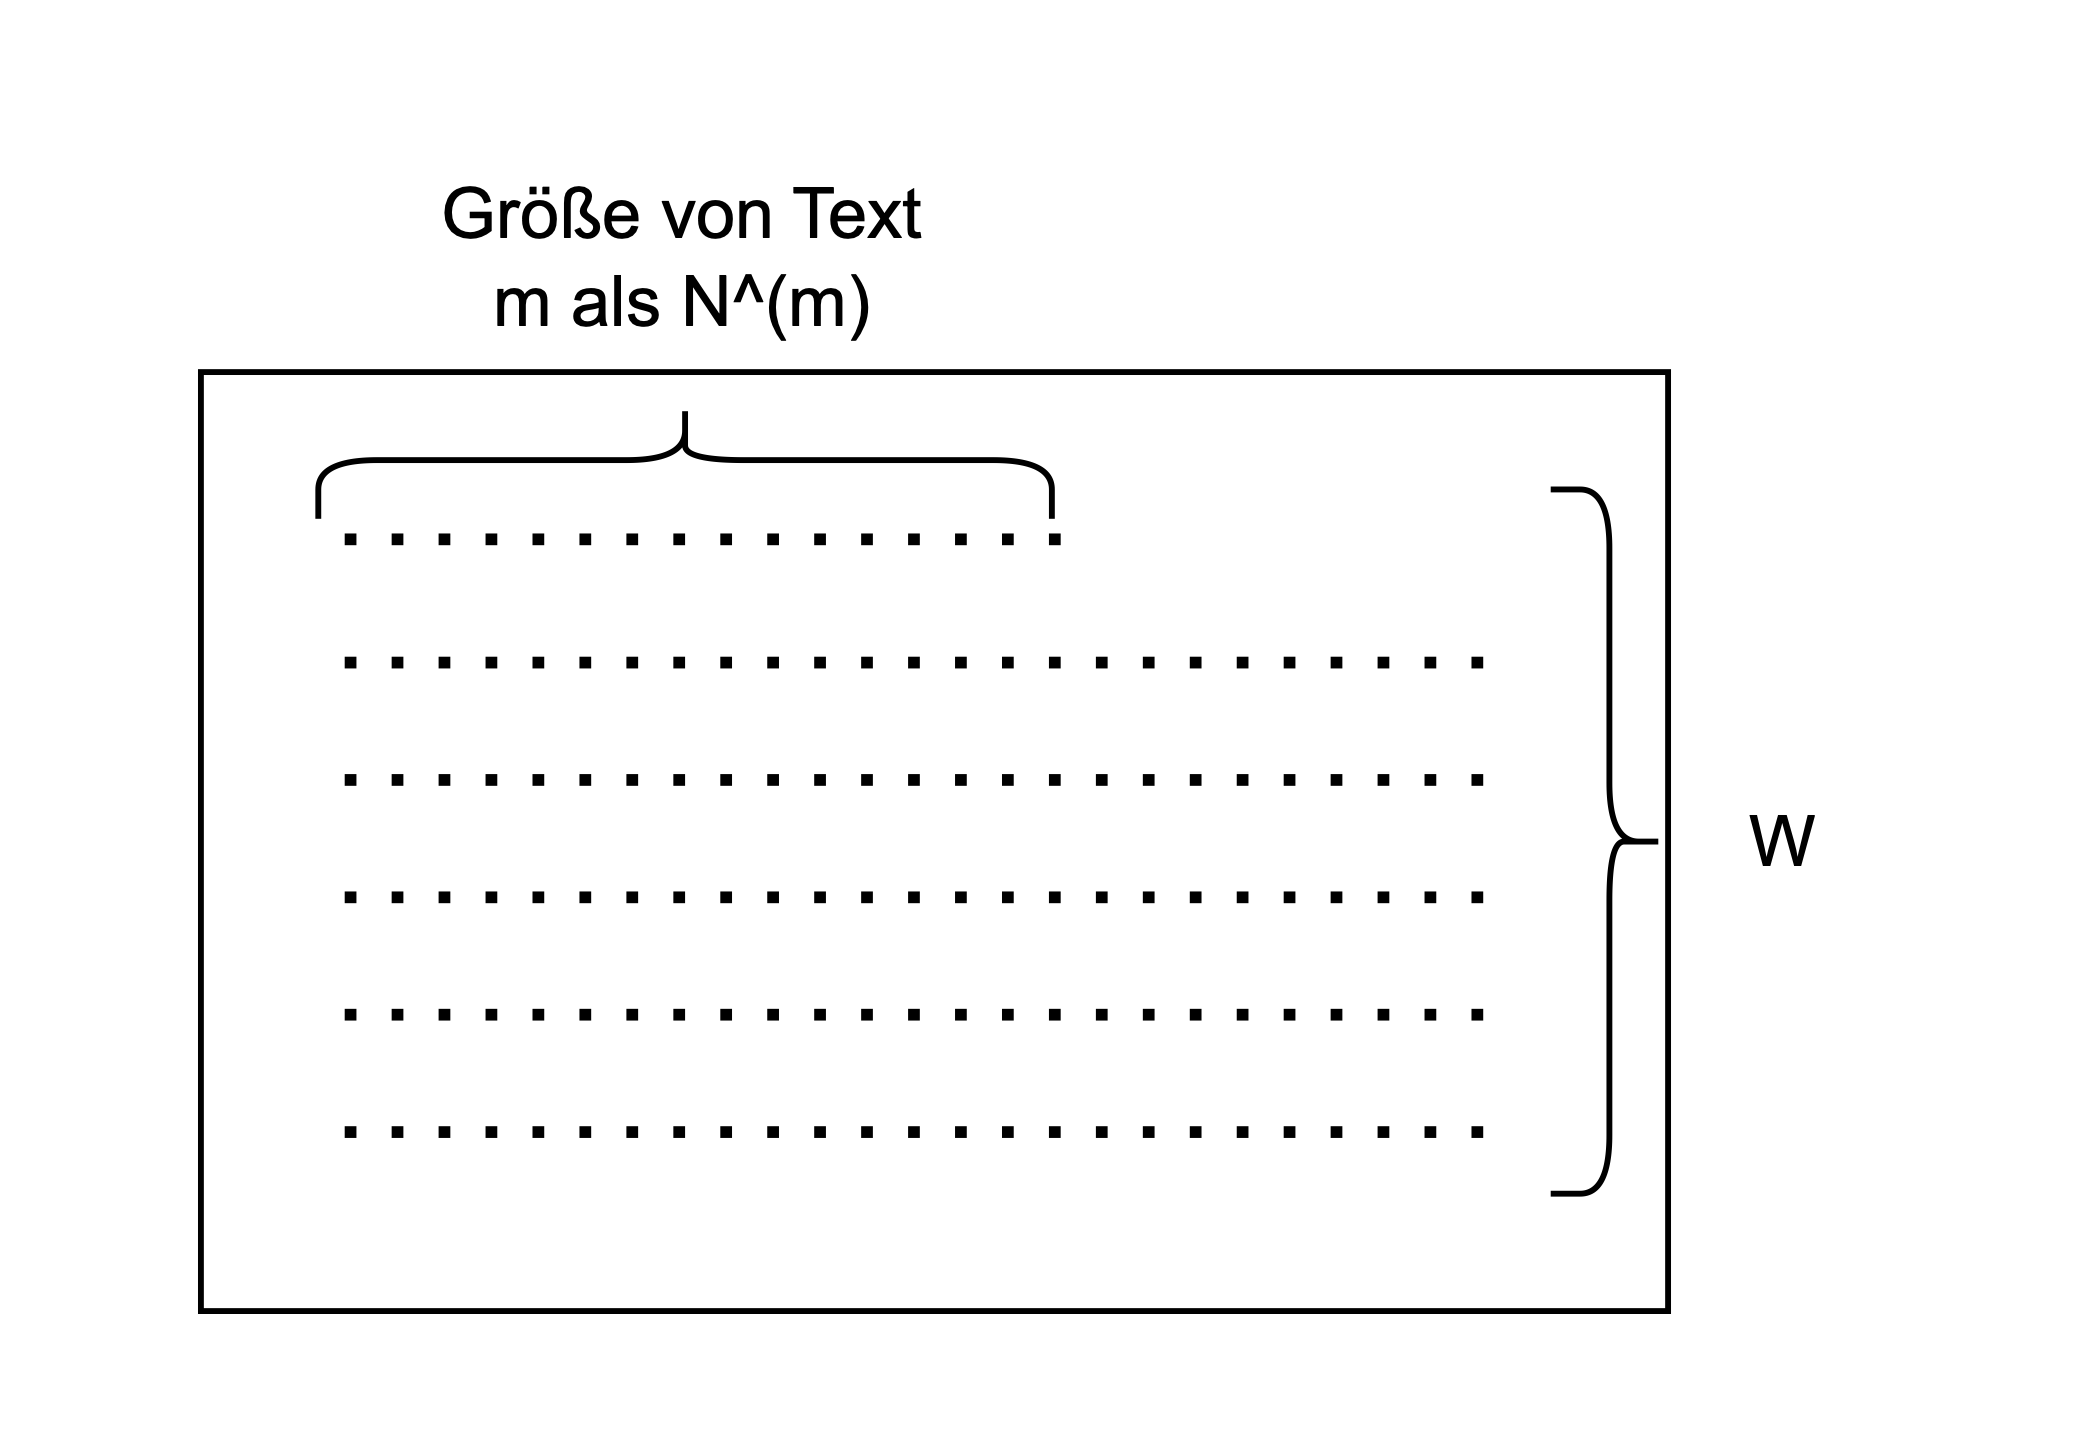

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

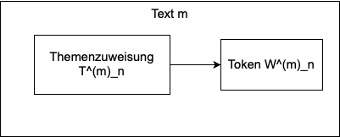

Um das Wahrscheinlichkeitsmodell für LDA aufzustellen sind folgende Definitionen und Annahmen notwendig: $n_k^((mv));k=1,…,K;v=1,…,V$ als Anzahl zugewiesener Wörter $v$ in Text $m$ zugehörig zu Thema $k$, dadurch lässt sich die Summe der Wörter $v$  in Thema $k$ über alle Dokumente $D$ mit $n_k^((*v))$ bestimmen. Wenn $w_k=(n_k^((*1)),…,n_k^((*V)) )^T$ die Vektoren der Wortanzahl für $k=1,…,K$ Themen ist, dann lässt sich mit diesen Definitionen das Modell wie folgt aufstellen:

$W_n^((m)) |T_n^((m)),ϕ_k  ~$ Discrete $(ϕ_k),		ϕ_k  ~$ Dirichlet $(η)$

$T_n^((m)) |θ_m  ~$ Discrete $(θ_m),		θ_m  ~$ Dirichlet $(α)$

Die Dirichlet Verteilungs Hyperparameter $α$ und $η$ müssen vom Nutzer deklariert werden. Da normalerweise keine a-priori (Anfangswahrscheinlichkeit) Informationen der Themen $θ$  und Wortverteilungen $ϕ$ vorliegen, werden $α$ und $η$ symmetrisch bestimmt (Rieger at al. (2020 Juni), S. 120).

Ein hoher $η$ Wert führt zu einem Verlust der Gleichmäßigkeit der Wortmischung pro Thema, ein niedriger $η$ Wert erhöht und verbessert die Gleichmäßigkeit wodurch weniger dominantere Wörter pro Thema zugeordnet werden. Nach dem gleichen Prinzip steuert α die Mischung der Themen in den Texten (Rieger at al. (2020 Juni), S. 120).


In [48]:
lda_model = LdaModel(corpus=corpus, id2word=id2word,
                    num_topics=unique_categories,
                    random_state=42,
                    passes=10,
                    alpha="auto",
                    per_word_topics=True)

In [49]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_lda)

Coherence Score: 0.2702485547213248


# Step 4: pyLDAvis

In [51]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
visualisation = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [ ]:
visualisation